In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from simple_hierarchical_topic_model import SimpleHierarchicalTopicModel, load_vocab, loadmat

In [3]:
np.random.seed(1)

In [4]:
class SimData(object):
    '''Generate a simulated dataset'''
    def __init__(self):
        self.vocab_size = 10
        self.num_docs = 20
        self.doc_length = 1000
        self.vocab = ["w{}".format(i) for i in range(self.vocab_size)]
        self.alpha_leaves = [1., 1.]
        self.alpha_depths = [1., 1.]
        self.init_topics()

    def init_topics(self):
        self.nodes = [(), (0,), (1,)]
        self.topics_by_path = dict()
        self.topics_by_index = []
        for node_index, path in enumerate(self.nodes):
            current_topic = np.ones(self.vocab_size)
            heavy_vocab_indices = slice(node_index * 2, (node_index + 1) * 2)
            current_topic[heavy_vocab_indices] *= 20
            current_topic /= current_topic.sum()
            self.topics_by_path[path] = current_topic
            self.topics_by_index.append(current_topic)
        self.topics_by_index = np.stack(self.topics_by_index)

    def generate(self):
        self.docs = []
        self.docs_aux = []

        for i in range(self.num_docs):
            leaf_distrib = np.random.dirichlet(self.alpha_leaves)
            depth_distrib = np.random.dirichlet(self.alpha_depths)
            node_distrib = np.array([
                    depth_distrib[0],
                    depth_distrib[1] * leaf_distrib[0],
                    depth_distrib[1] * leaf_distrib[1]])
            current_nodes = np.random.choice(self.nodes, size = self.doc_length, p = node_distrib)
            current_topics = [self.topics_by_path[current_nodes[j]] for j in range(self.doc_length)]
            current_doc = []
            for j in range(self.doc_length):
                word_index = np.random.choice(self.vocab_size, p = current_topics[j])
                current_doc.append(self.vocab[word_index])
            current_doc = " ".join(current_doc)
            self.docs.append(current_doc)
            self.docs_aux.append({
                "doc": current_doc,
                "leaf_distrib": leaf_distrib,
                "depth_distrib": depth_distrib,
                "node_distrib": node_distrib,
                "nodes_by_word_slot": current_nodes,
            })

        return self.docs

sim = SimData()
docs = sim.generate()
#docs

In [5]:
import os
import sys
sys.path.append(os.path.abspath(".."))
import text_utils

In [6]:
data, vocab = text_utils.document_strings_to_sparse_term_doc(
    docs = docs,
    tokenizer = text_utils.default_tokenizer,
    vocab = sim.vocab)

In [7]:
vocab

['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9']

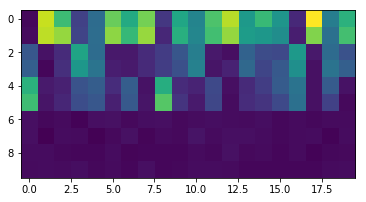

In [8]:
plt.imshow(data.todense());

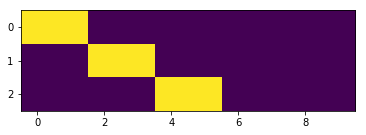

In [9]:
plt.imshow(sim.topics_by_index);

In [10]:
model = SimpleHierarchicalTopicModel(
    branching_factors = [2], num_epochs = 100,
    batch_size = 100, vocab = vocab)

In [11]:
model.fit(data)
top_words = model.get_top_words_by_node(num_words = 10)
model.print_top_words_by_node(num_words = 10);

100%|██████████| 2000/2000 [00:09<00:00, 212.47it/s, ELBO_previous=5.52e+06, Status=computing ELBO]

Top words by node:
()  : w0, w1, w3, w2, w4, w5, w6, w7, w9, w8
(0,): w0, w1, w3, w2, w4, w5, w6, w7, w9, w8
(1,): w0, w1, w3, w2, w4, w5, w6, w7, w9, w8


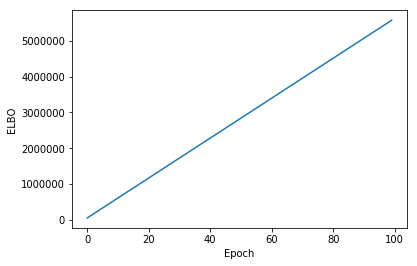

In [12]:
fig, ax = plt.subplots()
ax.plot(model.get_stats_by_epoch("ELBO"))
ax.set_xlabel("Epoch")
ax.set_ylabel("ELBO")
None

In [13]:
topic_vectors = model.get_expected_topic_vectors()

In [14]:
topic_vectors.shape

(3, 10)

In [15]:
variance = topic_vectors.var(axis=0)
print(variance.shape)
np.linalg.norm(variance)

(10,)


2.1137702116376638e-06

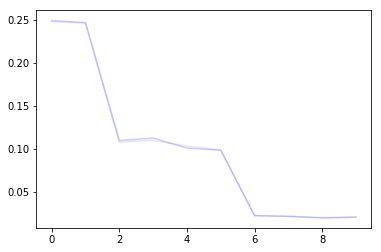

In [16]:
for i in range(3):
    plt.plot(topic_vectors[i,:], color='b', alpha=0.1);

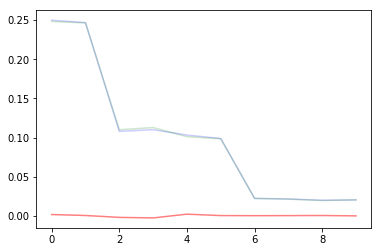

In [17]:
plt.plot(topic_vectors[0,:], color='b', alpha=0.2)
plt.plot(topic_vectors[1,:], color='g', alpha=0.2)
plt.plot(topic_vectors[0,:] - topic_vectors[1,:], color='r', alpha=0.5)
None